## Prueba de machine learning con un dataset de audio procesado

Importando las librerias requeridas

In [1]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.metrics import roc_curve, auc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
%matplotlib inline
plt.style.use('ggplot')

/home/zhyras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Agregamos los datos de audio ya procesados desde la carpeta data.

--------------------------------------------------------------------------------------------------------------------------

### Importando los datos de audio del dataset ya trabajado

In [13]:
data_dir = "data/us8k-np-ffn"

def add_folds():
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        print ("Agregando " + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print ("Caracteristicas nuevas ", loaded_features.shape)

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

### Definimos los conjuntos de prueba y entrenamiento

In [14]:
train_x, train_y = add_folds()

valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file) 

test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print ("Conjunto de entrenamiento:", train_x.shape, "Labels:", train_y.shape)
print ("Conjunto de validacion", valid_x.shape, "Labels:", valid_y.shape)
print ("Atributos del conjunto de prueba", test_x.shape, "Labels:", test_y.shape)

Agregando fold1
Caracteristicas nuevas  (873, 193)
Agregando fold2
Caracteristicas nuevas  (888, 193)
Agregando fold3
Caracteristicas nuevas  (925, 193)
Agregando fold4
Caracteristicas nuevas  (990, 193)
Agregando fold5
Caracteristicas nuevas  (936, 193)
Agregando fold6
Caracteristicas nuevas  (823, 193)
Agregando fold7
Caracteristicas nuevas  (838, 193)
Agregando fold8
Caracteristicas nuevas  (806, 193)
Conjunto de entrenamiento: (7079, 193) Labels: (7079, 10)
Conjunto de validacion (816, 193) Labels: (816, 10)
Atributos del conjunto de prueba (837, 193) Labels: (837, 10)


In [12]:
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 
n_hidden_units_3 = 200 

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print ("Atributos:", n_dim, "Clases:", n_classes)

Atributos 193 Clases: 10


In [5]:
tf.set_random_seed(0)
np.random.seed(0)

## Modelo con redes neuronales profundas

In [6]:
def create_model(activation_function='relu', init_type='normal', optimiser='Adamax', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

### Entrenamos el modelo y vemos su precision

In [7]:
# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
model = create_model()
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)

/home/zhyras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhyras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/home/zhyras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
  
/home/zhyras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
  
/home/zhyras/anaconda3/lib/python3.6/site-packages/keras/models.py:942: Use

Train on 7079 samples, validate on 816 samples
Epoch 1/30
7079/7079 [==============================] - 5s 731us/step - loss: 2.3034 - acc: 0.3092 - val_loss: 1.5481 - val_acc: 0.4461
Epoch 2/30
7079/7079 [==============================] - 5s 640us/step - loss: 1.5936 - acc: 0.4744 - val_loss: 1.4385 - val_acc: 0.4902
Epoch 3/30
7079/7079 [==============================] - 5s 669us/step - loss: 1.3320 - acc: 0.5670 - val_loss: 1.3871 - val_acc: 0.5245
Epoch 4/30
7079/7079 [==============================] - 5s 736us/step - loss: 1.1760 - acc: 0.6172 - val_loss: 1.3527 - val_acc: 0.5625
Epoch 5/30
7079/7079 [==============================] - 5s 683us/step - loss: 1.0434 - acc: 0.6559 - val_loss: 1.3794 - val_acc: 0.5711
Epoch 6/30
7079/7079 [==============================] - 5s 756us/step - loss: 0.9389 - acc: 0.6985 - val_loss: 1.4664 - val_acc: 0.5674
Epoch 7/30
7079/7079 [==============================] - 5s 699us/step - loss: 0.8612 - acc: 0.7272 - val_loss: 1.4779 - val_acc: 0.5993
E

### Curva ROC
La curva característica operativa del receptor (ROC) es una herramienta común utilizada con los clasificadores binarios. La curva ROC traza la tasa de verdaderos positivos (TVP) frente a la tasa de falsos positivos (TFP). La TFP es la proporción de instancias negativas que se clasifican incorrectamente como positivas. Es igual a uno menos la tasa de verdaderos negativos (TVN), que es la proporción de instancias negativas que se clasifican correctamente como negativas. El TVN también se llama especificidad. Por lo tanto, la curva ROC traza la sensibilidad (recuperación) versus (1 - especificidad). La precisión se mide por el área bajo la curva ROC. Un área de 1 representa una prueba perfecta; un área de .5 representa una prueba sin valor


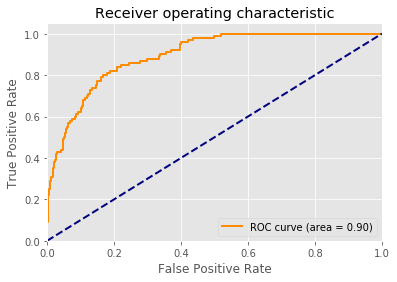

In [8]:
y_prob = model.predict_proba(test_x, verbose=0)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()